In [1]:
%pylab inline

from PyTools import err, binner
from itertools import product
import os
import pyfits as pyf

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("lines", linewidth=1.0)
rc("patch", linewidth=1.0)
rc("font", family="sans-serif", serif="Helvetica", size=20)
rc("savefig", dpi=92)
rc("legend", fontsize="x-small")
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")

kw = "M log_t_M log_t_L log_Z_M log_Z_L Av".split()
rl = [True]+5*[False]
lb = [r"$\Delta M_\star$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
      r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$",
      r"$\Delta A_V$"]

idir = "../inputs/real_deal6/Blues/"
odir = "../outputs/real_deal6/sanity_check/"

In [3]:
#READ DynBaS RESULTS: spec (13.75Gyr) + jpas (13.75Gyr) + yem (8Gyr + emission lines) + nem (8Gyr - emission lines)
table_kc_phot = genfromtxt(odir+"photo_ugriz_rf.txt", dtype=None, names=True)
table_ul_snem = genfromtxt(odir+"dynbas_spec_nem_uage_large.txt", dtype=None, names=True)
table_ul_jyem = genfromtxt(odir+"dynbas_jpas_yem_uage_large.txt", dtype=None, names=True)
table_ul_jnem = genfromtxt(odir+"dynbas_jpas_nem_uage_large.txt", dtype=None, names=True)
table_us_jyem = genfromtxt(odir+"dynbas_jpas_yem_uage_short.txt", dtype=None, names=True)
table_us_jnem = genfromtxt(odir+"dynbas_jpas_nem_uage_short.txt", dtype=None, names=True)

In [4]:
#CHECK TABLES
table_kc_phot = table_kc_phot[unique(table_kc_phot, True)[1]]
table_ul_snem = table_ul_snem[unique(table_ul_snem, True)[1]]
table_ul_jyem = table_ul_jyem[unique(table_ul_jyem, True)[1]]
table_ul_jnem = table_ul_jnem[unique(table_ul_jnem, True)[1]]
table_us_jyem = table_us_jyem[unique(table_us_jyem, True)[1]]
table_us_jnem = table_us_jnem[unique(table_us_jnem, True)[1]]

print "all tables consistent?", all([all(table_kc_phot["input_file"]==table_ul_snem["input_file"]),
                                     all(table_ul_snem["input_file"]==table_ul_jyem["input_file"]),
                                     all(table_ul_jyem["input_file"]==table_us_jyem["input_file"]),
                                     all(table_ul_jnem["input_file"]==table_us_jnem["input_file"]),
                                     all(table_us_jyem["input_file"]==table_us_jnem["input_file"])])

all tables consistent? True


In [5]:
#READ SNR AND EW FROM FITS
snr, ew_ha, ew_oiii = [], [], []
for fit in table_kc_phot["input_file"]:
    f = pyf.open(idir+fit)
    
    snr.append(f[0].header["SN_R"])
    ew_ha.append(f[2].data["ew"][35:38].sum())
    ew_oiii.append(f[2].data["ew"][29:31].sum())

#COMPUTE COMMON QUANTITIES
lcolor = table_kc_phot["u_mag"]-table_kc_phot["r_mag"]

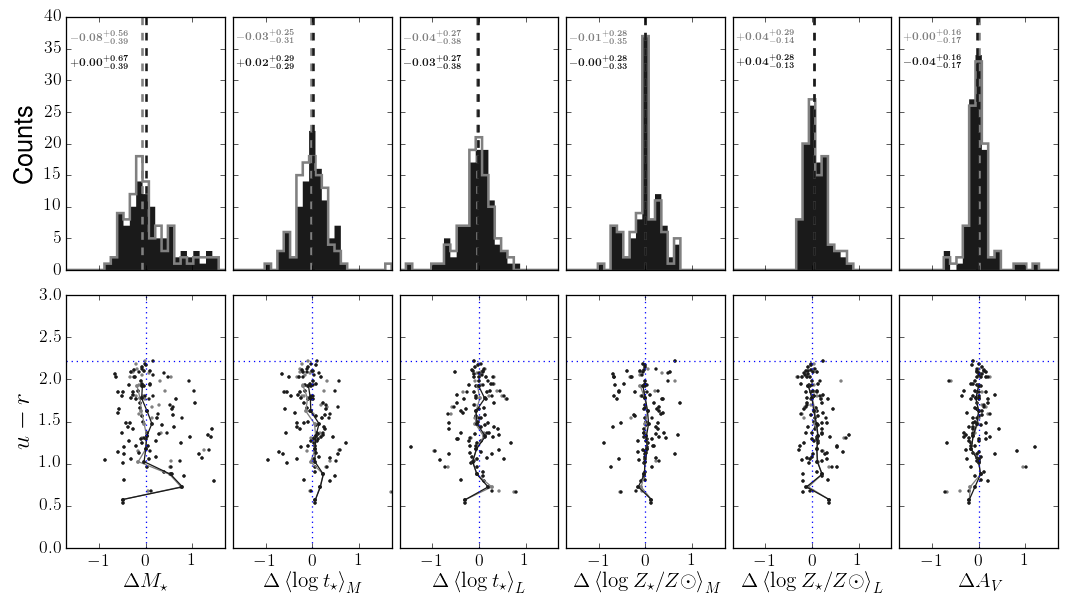

In [10]:
fig, axs = subplots(2, 6, figsize=(12, 7), sharex=True, sharey="row")

lm = xlim(-1.7, +1.7)
axs[0, 0].set_xticks([-1, 0, 1])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    res_ori = err(table_ul_snem[kw[j]], table_us_jnem[kw[j]], rl[j])
    res_san = err(table_ul_snem[kw[j]], table_ul_jnem[kw[j]], rl[j])
    med_ori = median(res_ori)
    med_san = median(res_san)
    p16_ori, p84_ori = percentile(res_ori, [16.0, 84.0])
    p16_san, p84_san = percentile(res_san, [16.0, 84.0])
    
    if j == 0:
        if i == 0: axs[i, j].set_ylabel("Counts")
        if i == 1: axs[i, j].set_ylabel(r"$u-r$")
    
    if i == 0:
        axs[i, j].hist(res_san, 25, range=lm, histtype="stepfilled", fc="0.1", lw=0)
        axs[i, j].hist(res_ori, 25, range=lm, histtype="step", ec="0.5", lw=2)
        
        axs[i, j].axvline(med_ori, ls="--", color="0.5", lw=2)
        axs[i, j].axvline(med_san, ls="--", color="0.1", lw=2)
        
        st_text_ori = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$"%(med_ori, p16_ori, p84_ori)
        st_text_san = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$"%(med_san, p16_san, p84_san)
        axs[i, j].text(0.02, 0.90, st_text_ori, fontsize=9, color="0.5", ha="left", transform=axs[i, j].transAxes)
        axs[i, j].text(0.02, 0.80, st_text_san, fontsize=9, color="0.1", ha="left", transform=axs[i, j].transAxes)
    else:
        x_ori, y_ori = binner(lcolor, res_ori, "median", 10, rang=(0.5, 2))
        x_san, y_san = binner(lcolor, res_san, "median", 10, rang=(0.5, 2))
        axs[i, j].plot(y_ori, x_ori, "-o", color="0.5", mew=0, ms=3)
        axs[i, j].plot(y_san, x_san, "-o", color="0.1", mew=0, ms=3)

        axs[i, j].scatter(res_ori, lcolor, s=7, lw=0, c="0.5")
        axs[i, j].scatter(res_san, lcolor, s=7, lw=0, c="0.1")

        axs[i, j].axvline(ls=":")
        axs[i, j].axhline(2.22, ls=":")
        
        axs[i, j].set_xlabel(lb[j], size="small")
        axs[i, j].set_ylim(0.0, 3.0)

tight_layout()
subplots_adjust(wspace=0.05, hspace=0.1)

#savefig("sanity_JPAS-SPEC.png", bbox_inches="tight")

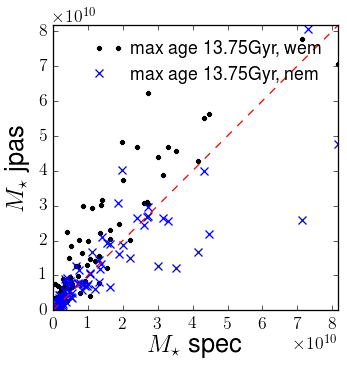

In [13]:
i=0
plot(table_ul_snem[kw[i]], table_ul_jyem[kw[i]], ".k", label="max age 13.75Gyr, wem")
plot(table_ul_snem[kw[i]], table_ul_jnem[kw[i]], "xb", label="max age 13.75Gyr, nem")

gca().set_aspect("equal")
lm = ylim(xlim(min(table_ul_snem[kw[i]]), max(table_ul_snem[kw[i]])))
plot(lm, lm, "--r")
legend(loc=0)

xlabel(lb[i].replace("\Delta", "")+" spec")
ylabel(lb[i].replace("\Delta", "")+" jpas")

#savefig("sanity_met_cons.png", bbox_inches="tight")

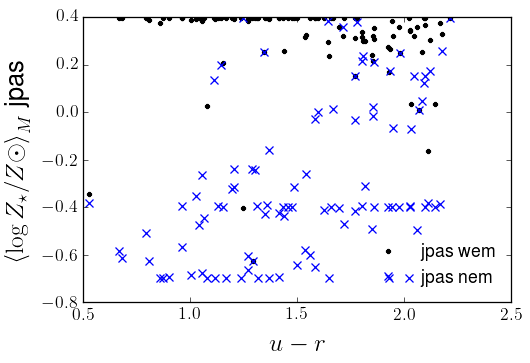

In [8]:
i=3
plot(lcolor, table_ul_jyem[kw[i]], ".k", label="jpas wem")
plot(lcolor, table_ul_jnem[kw[i]], "xb", label="jpas nem")
legend(loc=0)

xlabel("$u-r$")
ylabel(lb[i].replace("\Delta", "")+" jpas")